## Анализ результатов (сравнение метрик)
В качестве метрики для оценки в задании было предложено использовать `Accuracy`, что мы и оценим. Однако я хочу оценить также и `F1-score` из-за того, что в данных заметен значительный дизбаланс и метрика `Accuracy` будет нам "льстить".

| Negative (0)  | Positive (1)  |
| ------------- |:-------------:|
| 29753         | 2209          |
| 0.93          | 0.07          |


Для начала посмотрим, какие результаты показывает алгоритм до дообучения. И выберем подходящий treshold для того, чтобы производить классификацию.

### Imports & settings

In [1]:
from pathlib import Path

import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, f1_score
from matplotlib import pyplot as plt
from scipy.special import softmax

import json
import yaml

# Local imports
from model import RoBERTaClassification
from data import read_data

In [2]:
with open("config.yml") as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [6]:
def get_best_threshold(y_true, pred_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, pred_probs)
    fscore = (2 * precision * recall) / (precision + recall)

    # Find the optimal threshold
    index = np.argmax(fscore)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    fscoreOpt = round(fscore[index], ndigits = 4)
    recallOpt = round(recall[index], ndigits = 4)
    precisionOpt = round(precision[index], ndigits = 4)
    print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))
    print('Recall: {}, Precision: {}'.format(recallOpt, precisionOpt))
    
    return thresholdOpt
    

def plot_pr_curve(y_true, pred_probs):
    pr, rec, thr = precision_recall_curve(y_true, pred_probs)
    auc = roc_auc_score(y_true, pred_probs)

    plt.figure(figsize=(7, 7))
    plt.plot(rec, pr)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'AUC: {auc}')

    plt.show()
    
    return rec, pr
    
def get_report(y_true, pred_probs):
    threshold = get_best_threshold(y_true, pred_probs)

    class_predictions = [int(prob > threshold) for prob in pred_probs]
    print('\n(With best threshold) Accuracy: %.2f, F1: %.2f' % (accuracy_score(y_true, class_predictions),
                                   f1_score(y_true, class_predictions)))

    return plot_pr_curve(y_true, pred_probs)

### Before fine-tuning

In [9]:
with open("data/output/before_fine_tuning.txt", 'r') as fin:
    non_finetuned_data = json.load(fin)

non_finetuned_predictions = [max(pred.values()) for pred in non_finetuned_data]

In [10]:
non_finetuned_rec, non_finetuned_pr = get_report(results, non_finetuned_predictions)

NameError: name 'results' is not defined

### After fine-tuning

In [14]:
finetuned_predicions = np.loadtxt(fname=params["data"]["path_to_test_finetuned"])
finetuned_probs = softmax(finetuned_predicions, axis=1)[:, 1]
# finetuned_rec, finetuned_pr = get_report(results, finetuned_probs)

In [15]:
finetuned_predicions

array([[9.99990106e-01, 9.95251503e-06],
       [9.99990106e-01, 9.91000798e-06],
       [9.99989629e-01, 1.04146748e-05],
       ...,
       [9.99990582e-01, 9.44423209e-06],
       [9.99990225e-01, 9.73590159e-06],
       [9.99989867e-01, 1.01229216e-05]])

## Both on the same plot

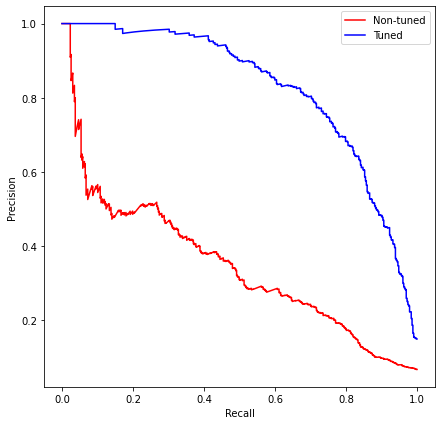

In [68]:
plt.figure(figsize=(7, 7))

plt.plot(non_finetuned_rec, non_finetuned_pr, c='r', label='Non-tuned')
plt.plot(finetuned_rec, finetuned_pr, c='b', label='Tuned')

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.show()